Some plotting functions for the BERT_MLM models.

In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [206]:
# Best test accuracy epoch
def find_best_epoch(metrics_csv):
    df = pd.read_csv(metrics_csv)
    best_epoch = df.loc[df['Test Accuracy'].idxmax()]
    return int(best_epoch['Epoch']), best_epoch['Test Accuracy'], best_epoch['Test Loss']

# Last epoch
def find_last_epoch(metrics_csv):
    df = pd.read_csv(metrics_csv)
    last_epoch = df.iloc[-1]
    return int(last_epoch['Epoch']), last_epoch['Test Accuracy'], last_epoch['Test Loss']

In [230]:
def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))  # 2 rows, 1 column
    fontsize = 28

    # Plot Loss
    ax1.plot(df['Epoch'], df['Train Loss'], label='Train Loss', color='tab:red', linewidth=3)
    ax1.plot(df['Epoch'], df['Test Loss'], label='Test Loss', color='tab:orange', linewidth=3)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_ylim(0, 4.3) 
    ax1.set_ylabel('Loss', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.legend(loc='upper right', fontsize=fontsize)

    # Plot Accuracy
    ax2.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', color='tab:blue', linewidth=3)
    ax2.plot(df['Epoch'], df['Test Accuracy'], label='Test Accuracy', color='tab:green', linewidth=3)
    ax2.set_xlabel('Epochs', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.set_ylim(0, 100) 
    ax2.set_ylabel('Accuracy', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='lower right', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')
    plt.savefig(metrics_img.replace('.pdf', '.png'), format='png')

def plot_comparative_log_file(metrics_csv_1, metrics_csv_2, metrics_img):
    df1 = pd.read_csv(metrics_csv_1)
    df2 = pd.read_csv(metrics_csv_2)

    sns.set_theme(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))  # 2 rows, 1 column
    fontsize = 28

    # Plot Loss
    ax1.plot(df1['Epoch'], df1['Train Loss'], label=f'Train Loss {metrics_csv_1.split("/")[4].upper()}', color='tab:red', linewidth=3)
    ax1.plot(df1['Epoch'], df1['Test Loss'], label=f'Test Loss {metrics_csv_1.split("/")[4].upper()}', color='tab:orange', linewidth=3)
    ax1.plot(df2['Epoch'], df2['Train Loss'], label=f'Train Loss {metrics_csv_2.split("/")[4].upper()}', color='tab:red', linestyle='--', linewidth=3)
    ax1.plot(df2['Epoch'], df2['Test Loss'], label=f'Test Loss {metrics_csv_2.split("/")[4].upper()}', color='tab:orange', linestyle='--', linewidth=3)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_ylim(0, 4.3)
    ax1.set_ylabel('Loss', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.legend(loc='upper right', fontsize=fontsize)

    # Plot Accuracy
    ax2.plot(df1['Epoch'], df1['Train Accuracy'], label=f'Train Accuracy {metrics_csv_1.split("/")[4].upper()}', color='tab:blue', linewidth=3)
    ax2.plot(df1['Epoch'], df1['Test Accuracy'], label=f'Test Accuracy {metrics_csv_1.split("/")[4].upper()}', color='tab:green', linewidth=3)
    ax2.plot(df2['Epoch'], df2['Train Accuracy'], label=f'Train Accuracy {metrics_csv_2.split("/")[4].upper()}', color='tab:blue', linestyle='--', linewidth=3)
    ax2.plot(df2['Epoch'], df2['Test Accuracy'], label=f'Test Accuracy {metrics_csv_2.split("/")[4].upper()}', color='tab:green', linestyle='--', linewidth=3)
    ax2.set_xlabel('Epochs', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Accuracy', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='lower right', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')
    plt.savefig(metrics_img.replace('.pdf', '.png'), format='png')

In [231]:
def plot_aa_preds_heatmap(preds_csv, preds_img, cutoff_epoch=None):
    """
    Plots heatmap of expected vs predicted amino acid incorrect prediction counts.
    Expected on x axis.
    
    Parameters:
    - preds_csv: path to the CSV file with predictions
    - preds_img: path to save the output image
    - cutoff_epoch: if provided, only consider predictions up to this epoch
    """
    df = pd.read_csv(preds_csv)

    # Create a DataFrame with all possible amino acid combinations
    ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
    all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
    all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

    # Split 'expected_aa->predicted_aa' into separate columns
    df[['Expected', 'Predicted']] = df['expected_aa->predicted_aa'].str.split('->', expand=True)

    # Ensure that the epoch columns are numeric and fill any NaNs with 0
    epoch_columns = df.columns[1:-2]  # Assuming epoch columns start at index 1 and go up to the second last column
    df[epoch_columns] = df[epoch_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    # If cutoff_epoch is provided, only consider epochs up to that point
    if cutoff_epoch is not None:
        epoch_columns = [col for col in epoch_columns if int(col.split()[1]) <= cutoff_epoch]

    # Sum the counts across all epochs (or up to cutoff_epoch) to get the total error count for each expected->predicted pair
    total_count = df[epoch_columns].sum(axis=1)
    df = pd.concat([df, total_count.rename('Total Count')], axis=1)

    # Merge with all possible amino acid combinations so missing pairs get a count of 0
    df = pd.merge(all_df, df[['Expected', 'Predicted', 'Total Count']], how="left", on=["Expected", "Predicted"])
    df["Total Count"].fillna(0, inplace=True)

    # Calculate the total counts for each expected amino acid
    total_counts = df.groupby("Expected")["Total Count"].sum()
    df["Expected Total"] = df["Expected"].map(total_counts)

    # Calculate error percentage
    df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
    df["Error Percentage"].fillna(0, inplace=True)

    # Pivot the DataFrame to create a heatmap data structure
    heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

    # Set figure size
    plt.figure(figsize=(16, 9))
    fontsize=16

    # Plot
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    heatmap = sns.heatmap(
        heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap=cmap, vmin=0, vmax=100,
        annot_kws={"size": 13},
        cbar_kws={'drawedges': False, 'label': 'Prediction Rate (%)'}
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick label size
    colorbar.set_label('Prediction Rate (%)', size=fontsize)  # Set colorbar label size

    plt.ylabel('Predicted Amino Acid', fontsize=fontsize)
    plt.xlabel('Expected Amino Acid', fontsize=fontsize)
    plt.xticks(rotation=0, fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    if cutoff_epoch is not None:
        title = f"Best Epoch {cutoff_epoch}"
        plt.title(title, fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(preds_img, format='pdf')
    plt.savefig(preds_img.replace('.pdf', '.png'), format='png')

def plot_aa_preds_subtractive_heatmap(preds_csv_1, preds_csv_2, preds_img, cutoff_epoch_1=None, cutoff_epoch_2=None):
    """
    Plots subtractive heatmap of expected vs predicted amino acid incorrect prediction counts.
    The difference is calculated as the heatmap of model 1 minus model 2.
    
    Parameters:
    - preds_csv_1: path to the first CSV file with predictions
    - preds_csv_2: path to the second CSV file with predictions
    - preds_img: path to save the output image
    - cutoff_epoch_1: if provided, only consider predictions up to this epoch for the first CSV
    - cutoff_epoch_2: if provided, only consider predictions up to this epoch for the second CSV
    """
    def calculate_heatmap_data(preds_csv, cutoff_epoch=None):
        # Read the CSV file
        df = pd.read_csv(preds_csv)

        # Create a DataFrame with all possible amino acid combinations
        ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
        all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
        all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

        # Split 'expected_aa->predicted_aa' into separate columns
        df[['Expected', 'Predicted']] = df['expected_aa->predicted_aa'].str.split('->', expand=True)

        # Ensure that the epoch columns are numeric and fill any NaNs with 0
        epoch_columns = df.columns[1:-2]  # Assuming epoch columns start at index 1 and go up to the second last column
        df[epoch_columns] = df[epoch_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

        # If cutoff_epoch is provided, only consider epochs up to that point
        if cutoff_epoch is not None:
            epoch_columns = [col for col in epoch_columns if int(col.split()[1]) <= cutoff_epoch]

        # Sum the counts across all epochs (or up to cutoff_epoch) to get the total error count for each expected->predicted pair
        total_count = df[epoch_columns].sum(axis=1)
        df = pd.concat([df, total_count.rename('Total Count')], axis=1)

        # Merge with all possible amino acid combinations so missing pairs get a count of 0
        df = pd.merge(all_df, df[['Expected', 'Predicted', 'Total Count']], how="left", on=["Expected", "Predicted"])
        df["Total Count"].fillna(0, inplace=True)

        # Calculate the total counts for each expected amino acid
        total_counts = df.groupby("Expected")["Total Count"].sum()
        df["Expected Total"] = df["Expected"].map(total_counts)

        # Calculate error percentage
        df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
        df["Error Percentage"].fillna(0, inplace=True)

        # Pivot the DataFrame to create a heatmap data structure
        heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

        return heatmap_data

    # Calculate heatmap data for both models
    heatmap_data_1 = calculate_heatmap_data(preds_csv_1, cutoff_epoch_1)
    heatmap_data_2 = calculate_heatmap_data(preds_csv_2, cutoff_epoch_2)

    # Subtract heatmap 1 from heatmap 2 to create the difference heatmap
    subtractive_heatmap_data = heatmap_data_2 - heatmap_data_1

    # Set figure size
    plt.figure(figsize=(16, 9))
    fontsize=16

    # Plot the subtractive heatmap
    cmap = sns.color_palette("RdBu", as_cmap=True)
    heatmap = sns.heatmap(
        subtractive_heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap=cmap, vmin=-100, vmax=100,
        annot_kws={"size": 13},
        cbar_kws={'drawedges': False, 'label': 'Difference in Prediction Rate %'}
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick label size
    colorbar.set_label('Difference in Prediction Rate %', size=fontsize)  # Set colorbar label size

    plt.ylabel('Predicted Amino Acid', fontsize=fontsize)
    plt.xlabel('Expected Amino Acid', fontsize=fontsize)
    plt.xticks(rotation=0, fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    if cutoff_epoch_1 is not None or cutoff_epoch_2 is not None:
        title = f"{preds_csv_1.split('/')[4].upper()} (Epoch {cutoff_epoch_1 if cutoff_epoch_1 is not None else ''}) vs "
        title += f"{preds_csv_2.split('/')[4].upper()} (Epoch {cutoff_epoch_2 if cutoff_epoch_2 is not None else ''})"
    plt.title(title, fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(preds_img, format='pdf')
    plt.savefig(preds_img.replace('.pdf', '.png'), format='png')

## Base model (same for both ESM initialized and not)
GPUs: ***1***

Parameters
- n_epochs = ***100***
- batch_size = ***64***
- max_batch = ***-1***
- num_workers = ***64***

Optimizer/Scheduler
- lr = ***1e-5***
- betas = ***(0.9, 0.999)***
- weight_decay = ***0.01***
- d_model = model.bert.embedding_dim: ***320***
- n_warmup_steps = (len(train_data_loader.dataset) / train_data_loader.batch_size) \* 0.1: (277945/64) \* 0.1 = ***434.2890625***

BERT
- max_len = ***280***
- mask_prob = ***0.15***
- embedding_dim = ***320*** 
- dropout = ***0.1***
- n_transformer_layers = ***12***
- n_attn_heads = ***10***

Best BERT_MLM: 
	Epoch: 77
	Test Accuracy: 71.7893 
	Test Loss: 1.3737

Last BERT_MLM: 
	Epoch: 100
	Test Accuracy: 68.1478 
	Test Loss: 1.3767



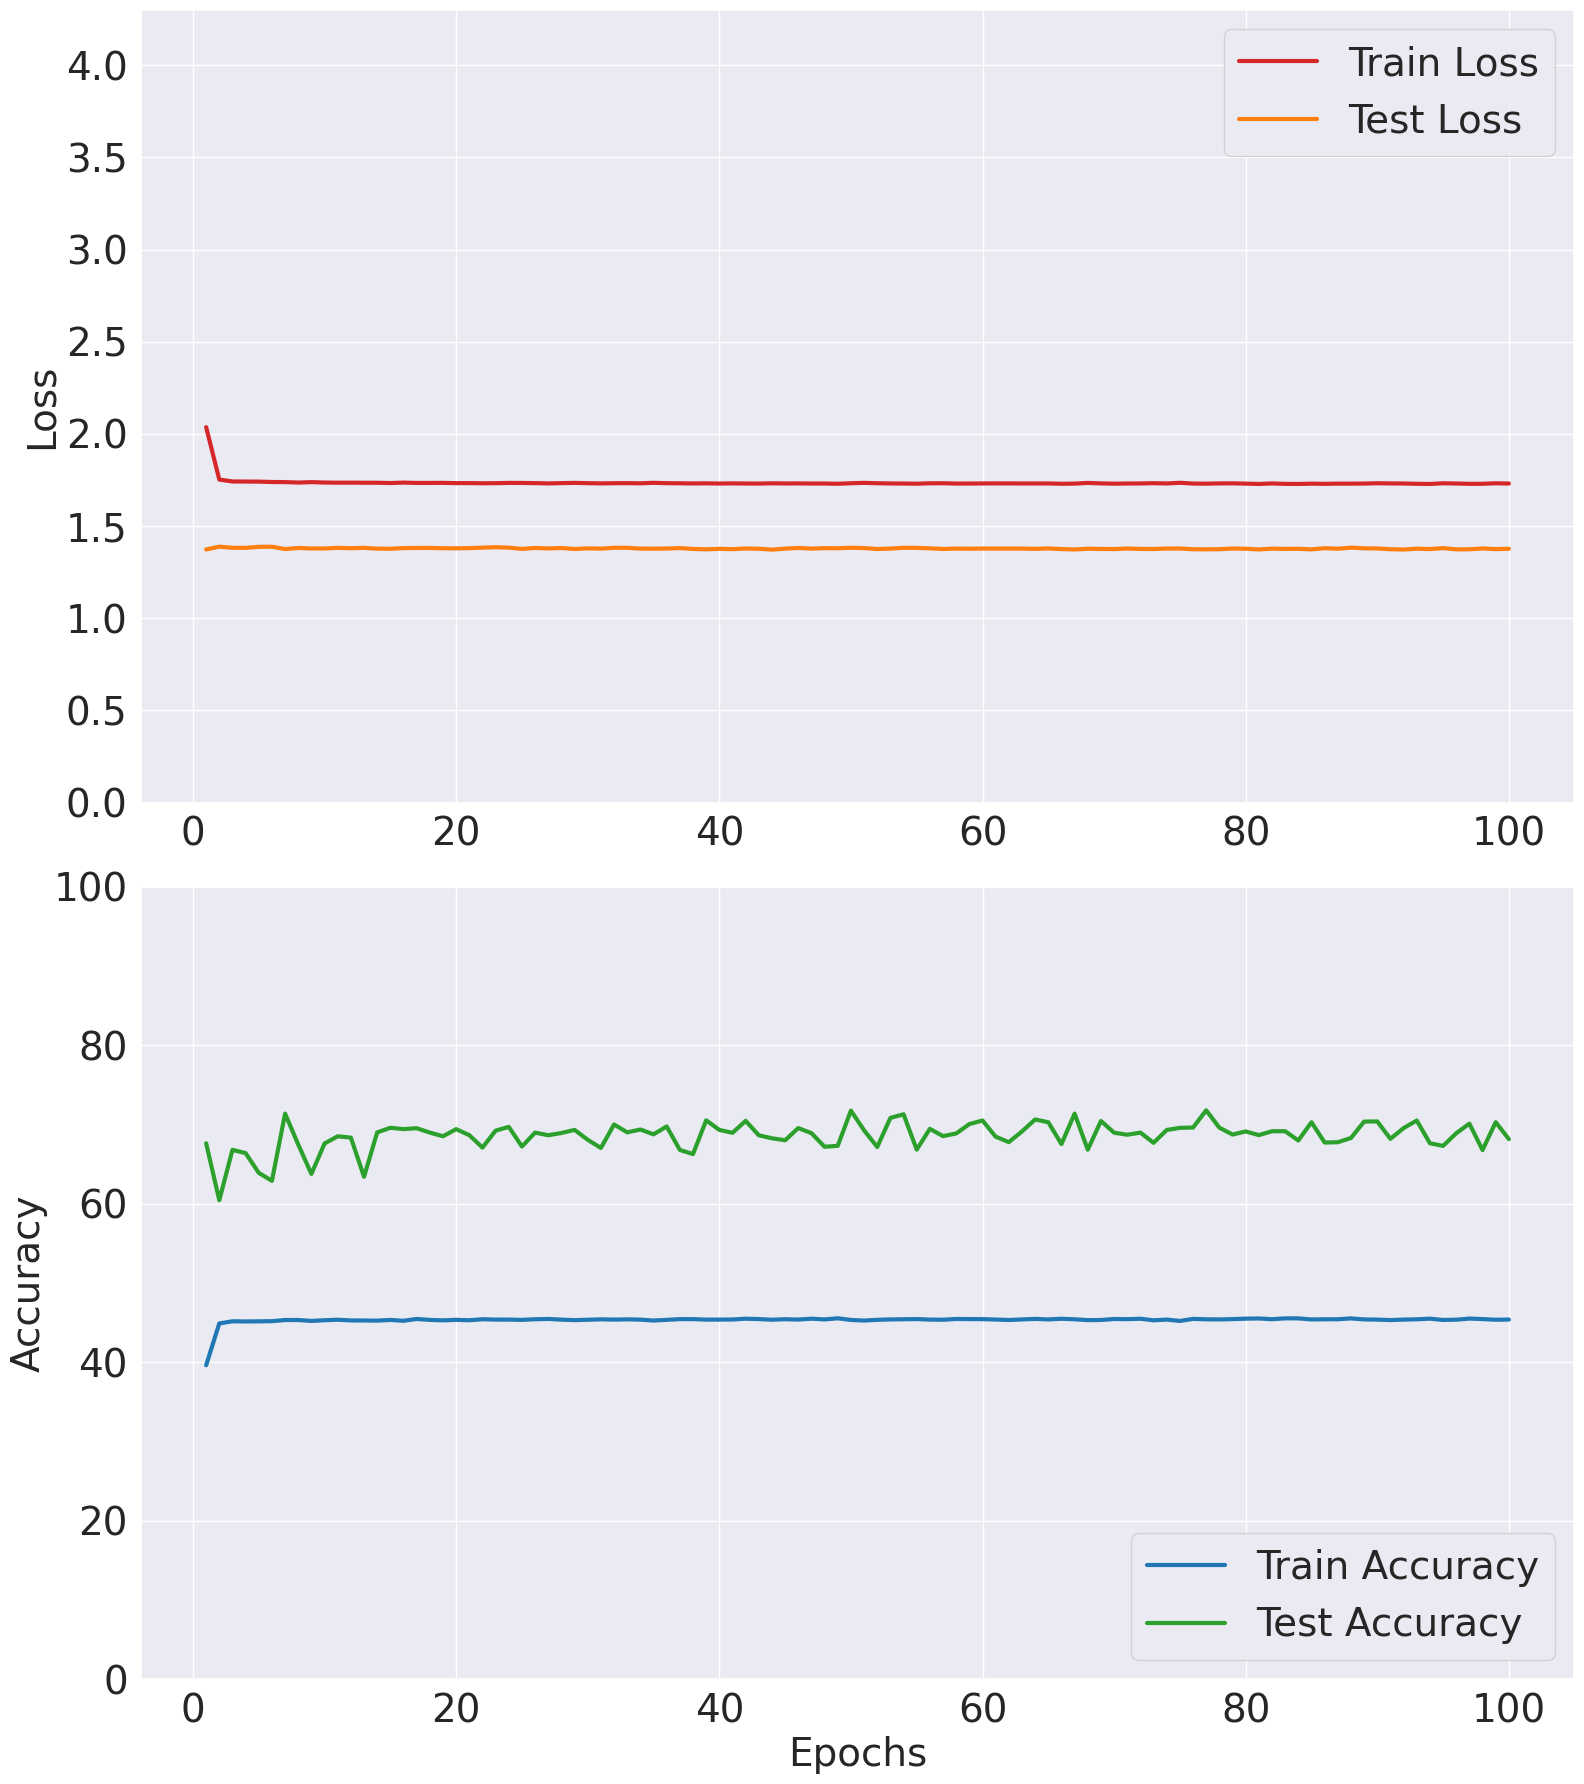

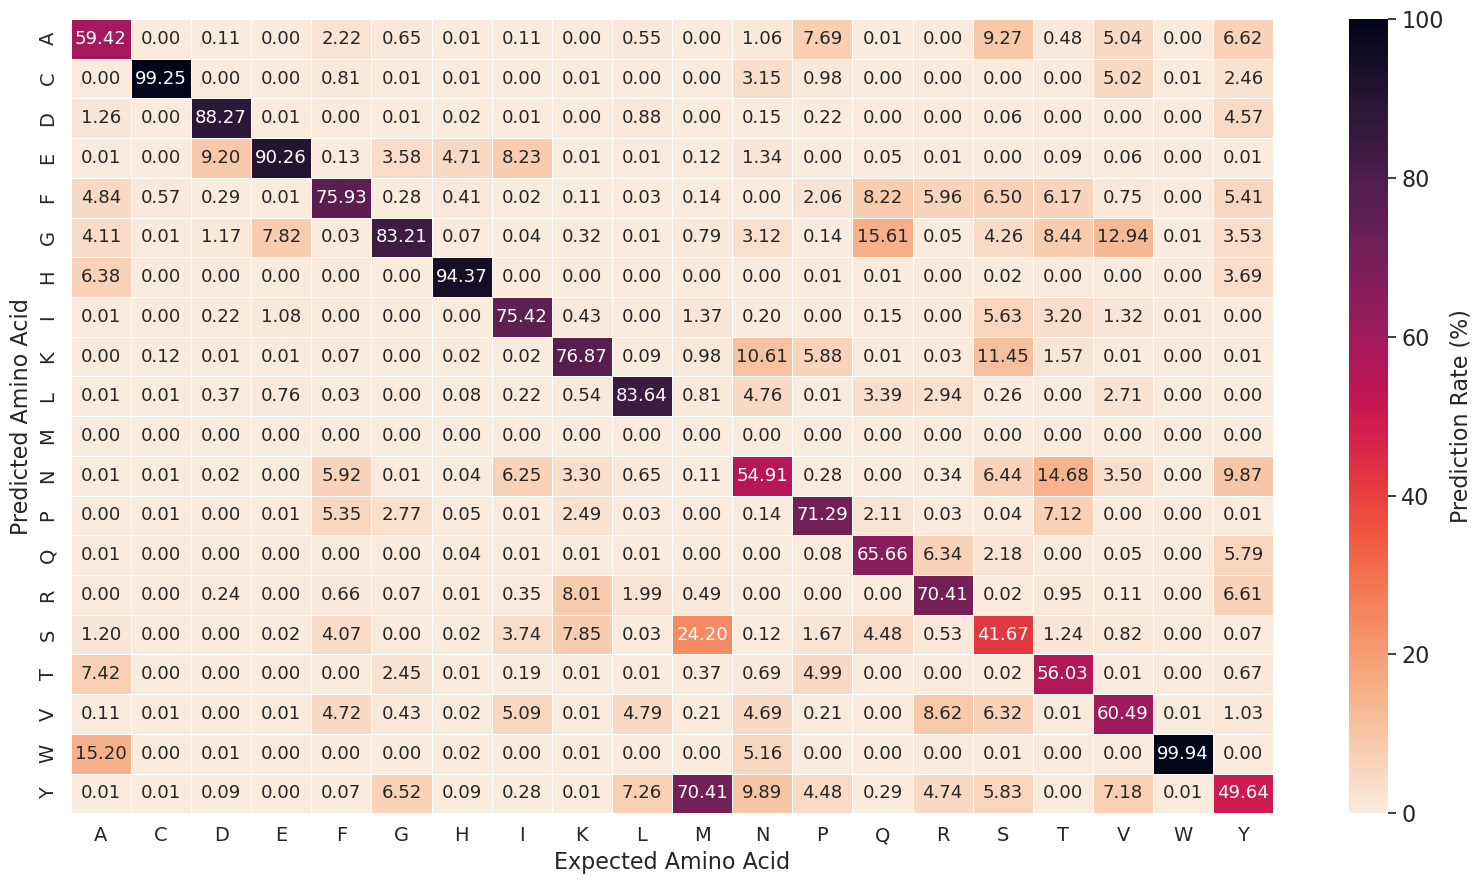

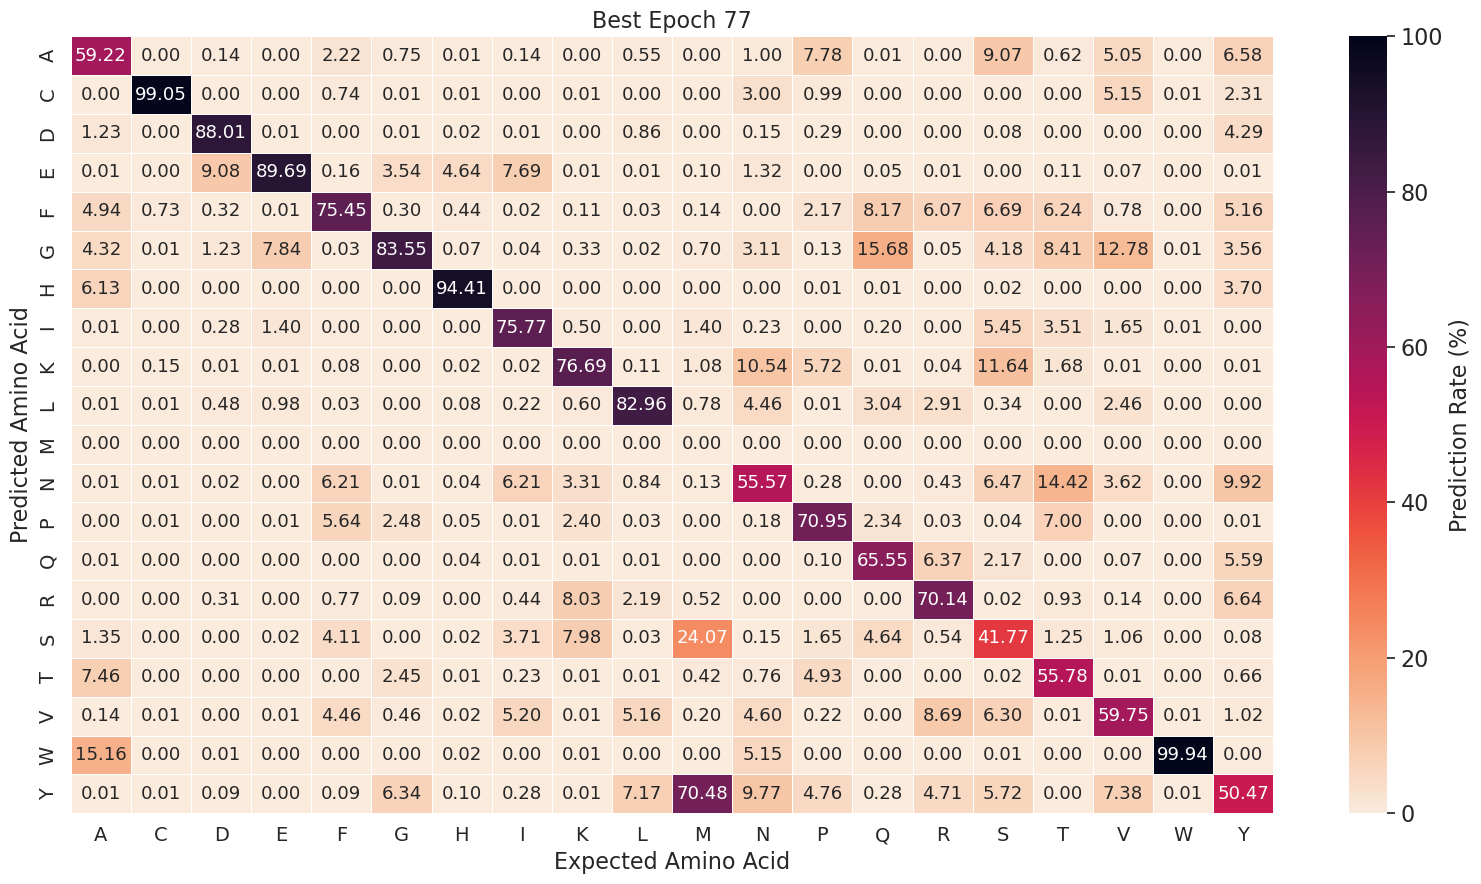

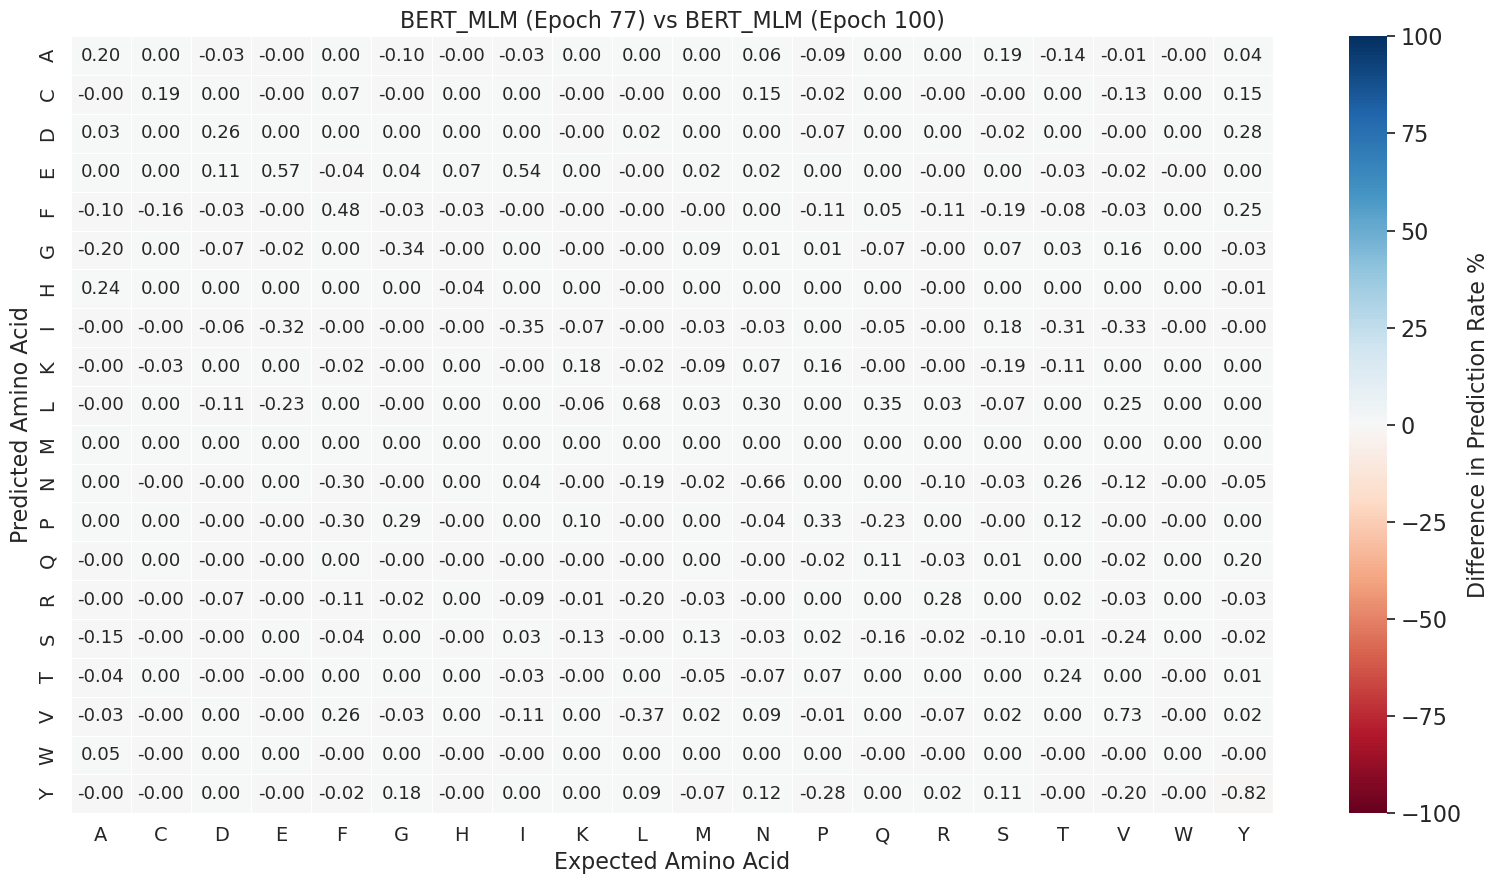

In [232]:
# BERT-MLM
run1 = "../../results/run_results/bert_mlm/bert_mlm-rbd-2024-09-25_20-28/bert_mlm-RBD-train_277945_test_69487"
plot_log_file(run1 + "_metrics.csv", run1 + "_metrics.pdf")

run1_best_results = find_best_epoch(run1 + "_metrics.csv")
print(f"Best {run1.split('/')[4].upper()}: \n\tEpoch: {run1_best_results[0]}\n\tTest Accuracy: {run1_best_results[1]:.4f} \n\tTest Loss: {run1_best_results[2]:.4f}\n")
run1_last_results = find_last_epoch(run1 + "_metrics.csv")
print(f"Last {run1.split('/')[4].upper()}: \n\tEpoch: {run1_last_results[0]}\n\tTest Accuracy: {run1_last_results[1]:.4f} \n\tTest Loss: {run1_last_results[2]:.4f}\n")

# Last Epoch
plot_aa_preds_heatmap(run1 + "_predictions.csv", run1 + "_predictions.pdf")

# Best Test Accuracy Epoch
plot_aa_preds_heatmap(run1 + "_predictions.csv", run1 + "_best_predictions.pdf", cutoff_epoch = run1_best_results[0])

# Compare the best vs last epoch
preds_img = run1 + f"_best_{run1.split('/')[4]}.vs.last_{run1.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run1 + "_predictions.csv", 
    preds_csv_2=run1 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run1_best_results[0], 
    cutoff_epoch_2=run1_last_results[0]
)

---

Best BERT_MLM-ESM_INIT: 
	Epoch: 90
	Test Accuracy: 96.2419 
	Test Loss: 0.1704

Last BERT_MLM-ESM_INIT: 
	Epoch: 100
	Test Accuracy: 95.9709 
	Test Loss: 0.1725



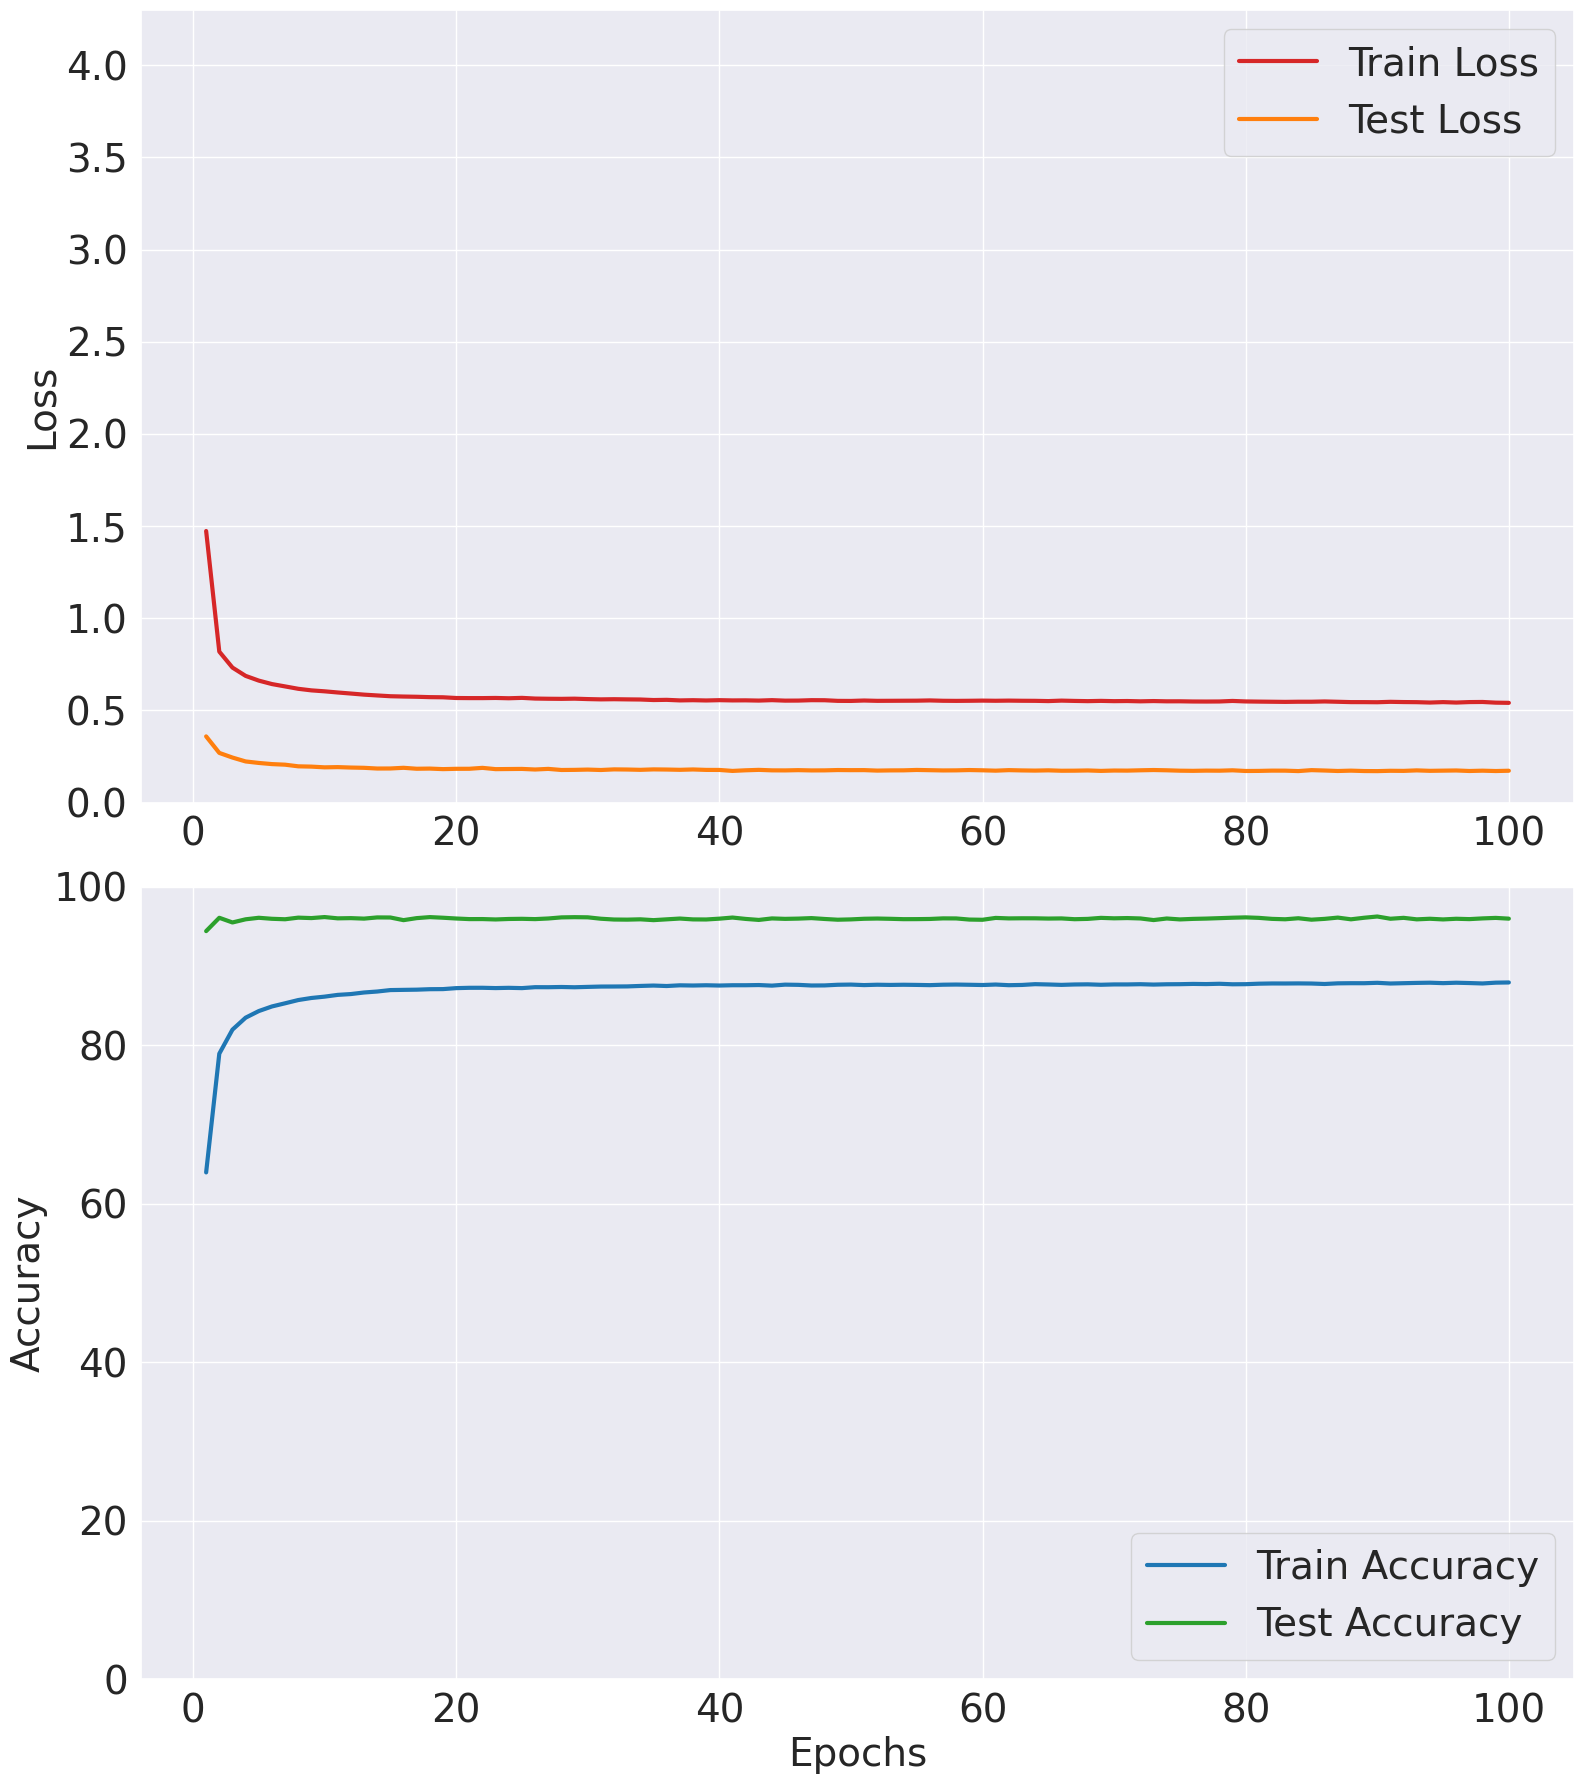

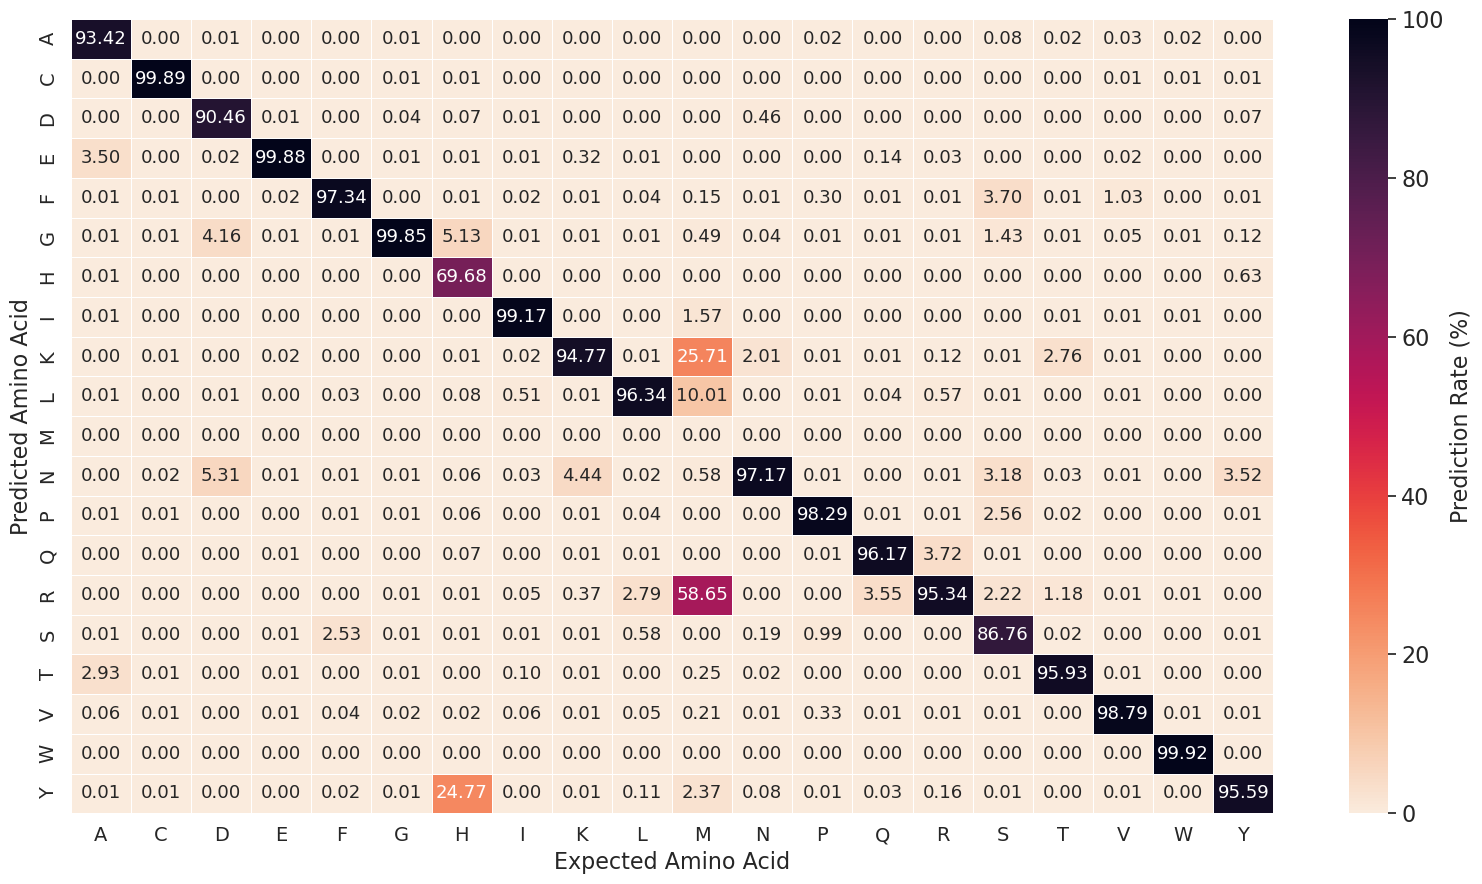

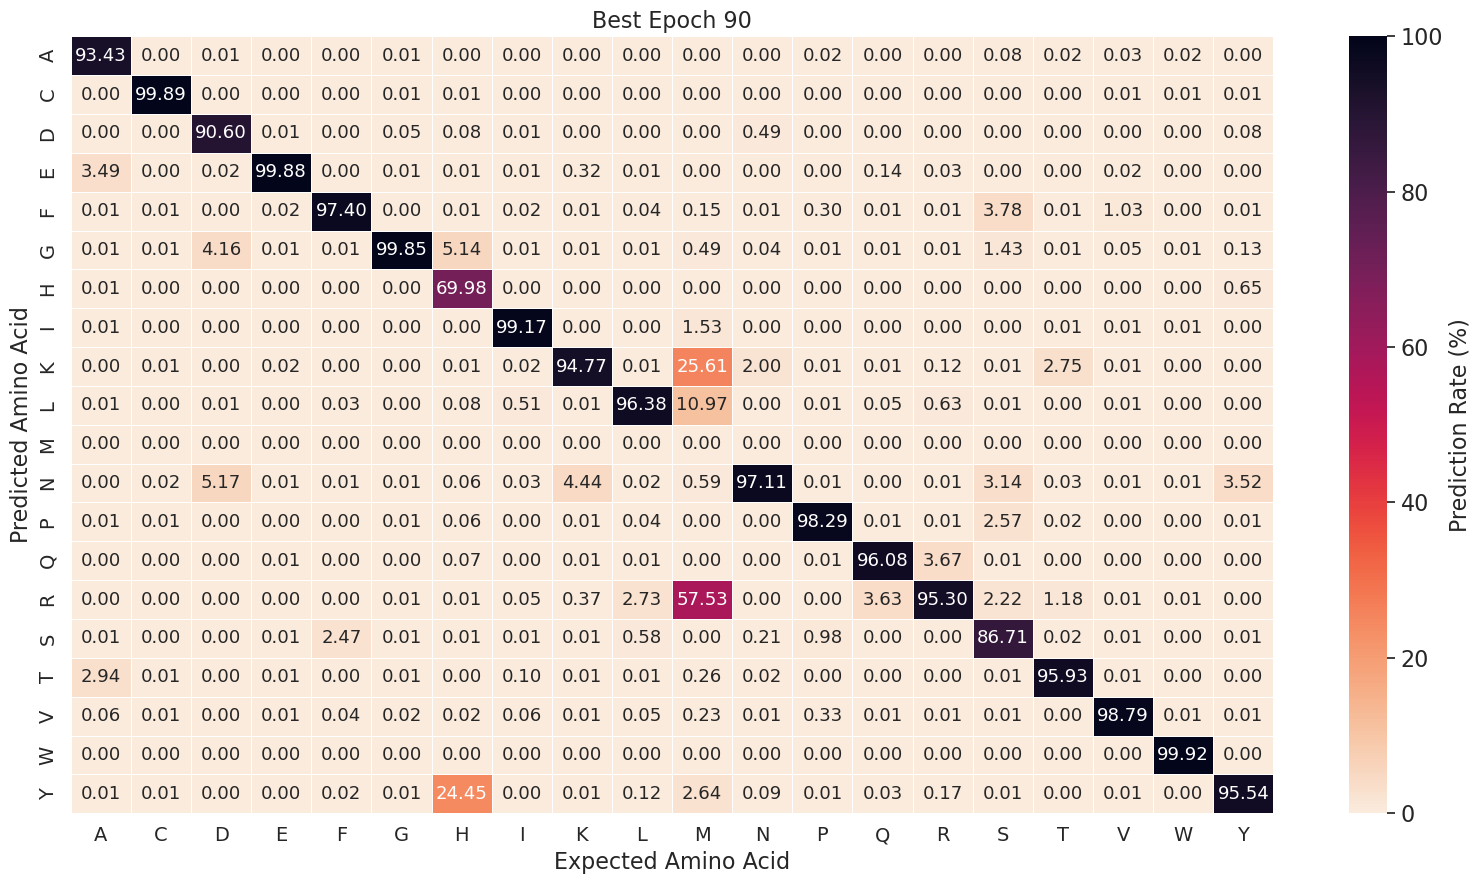

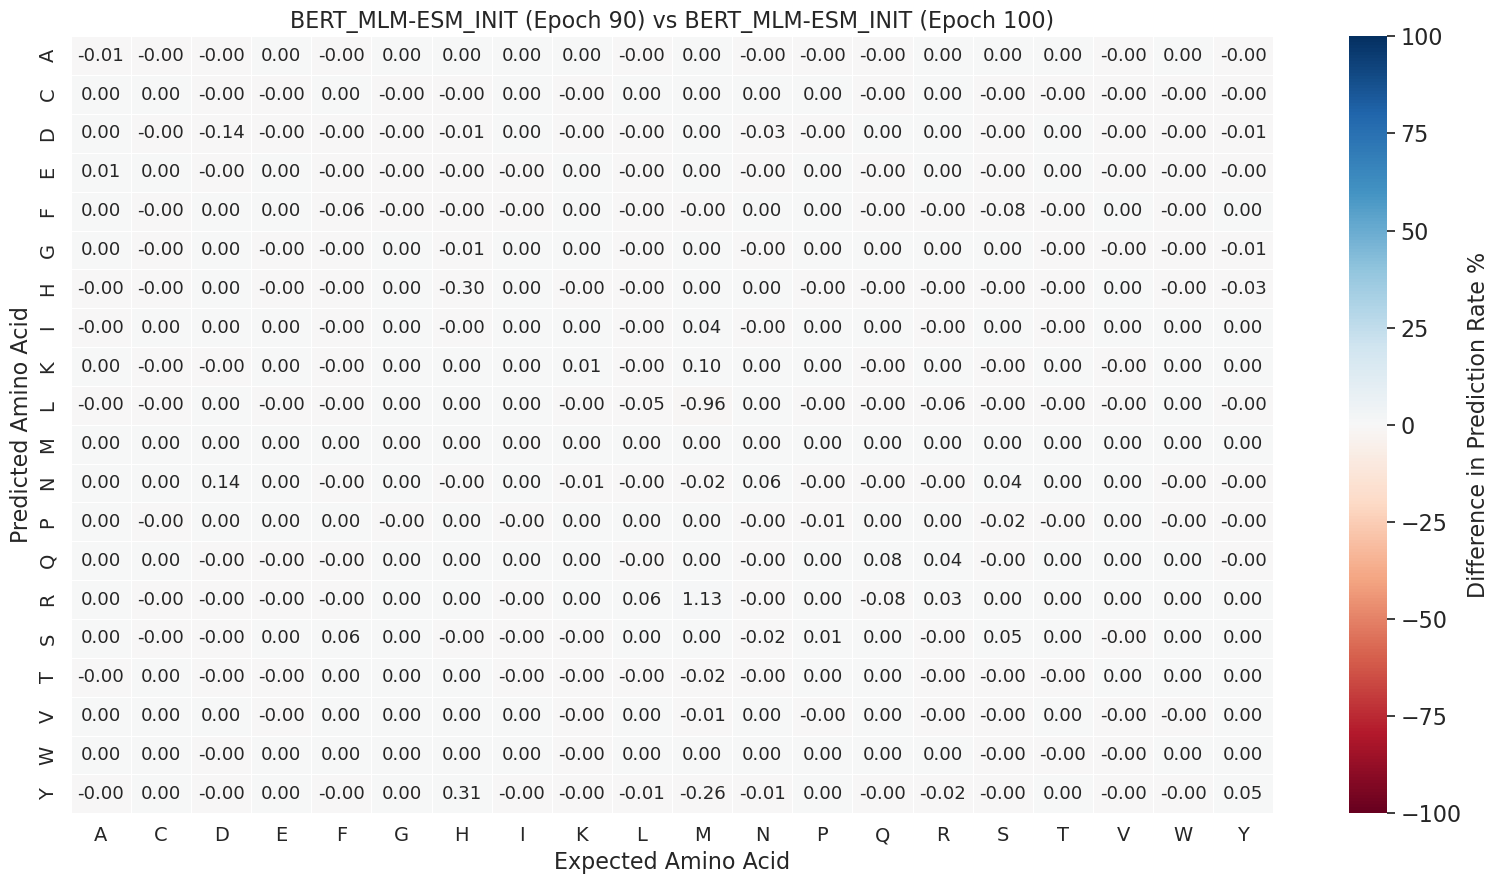

In [233]:
# BERT-MLM INITIALIZED WITH ESM
run2 = "../../results/run_results/bert_mlm-esm_init/bert_mlm-esm_init-rbd-2024-09-25_20-29/bert_mlm-esm_init-RBD-train_277945_test_69487"
plot_log_file(run2 + "_metrics.csv", run2 + "_metrics.pdf")

run2_best_results = find_best_epoch(run2 + "_metrics.csv")
print(f"Best {run2.split('/')[4].upper()}: \n\tEpoch: {run2_best_results[0]}\n\tTest Accuracy: {run2_best_results[1]:.4f} \n\tTest Loss: {run2_best_results[2]:.4f}\n")
run2_last_results = find_last_epoch(run2 + "_metrics.csv")
print(f"Last {run2.split('/')[4].upper()}: \n\tEpoch: {run2_last_results[0]}\n\tTest Accuracy: {run2_last_results[1]:.4f} \n\tTest Loss: {run2_last_results[2]:.4f}\n")

# Last Epoch
plot_aa_preds_heatmap(run2 + "_predictions.csv", run2 + "_predictions.pdf")

# Best Test Accuracy Epoch
plot_aa_preds_heatmap(run2 + "_predictions.csv", run2 + "_best_predictions.pdf", cutoff_epoch = run2_best_results[0])

# Compare the best vs last epoch
preds_img = run2 + f"_best_{run2.split('/')[4]}.vs.last_{run2.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run2 + "_predictions.csv", 
    preds_csv_2=run2 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run2_best_results[0], 
    cutoff_epoch_2=run2_last_results[0]
)

---
### Base Model Comparison - Subtractive heatmap and model runs

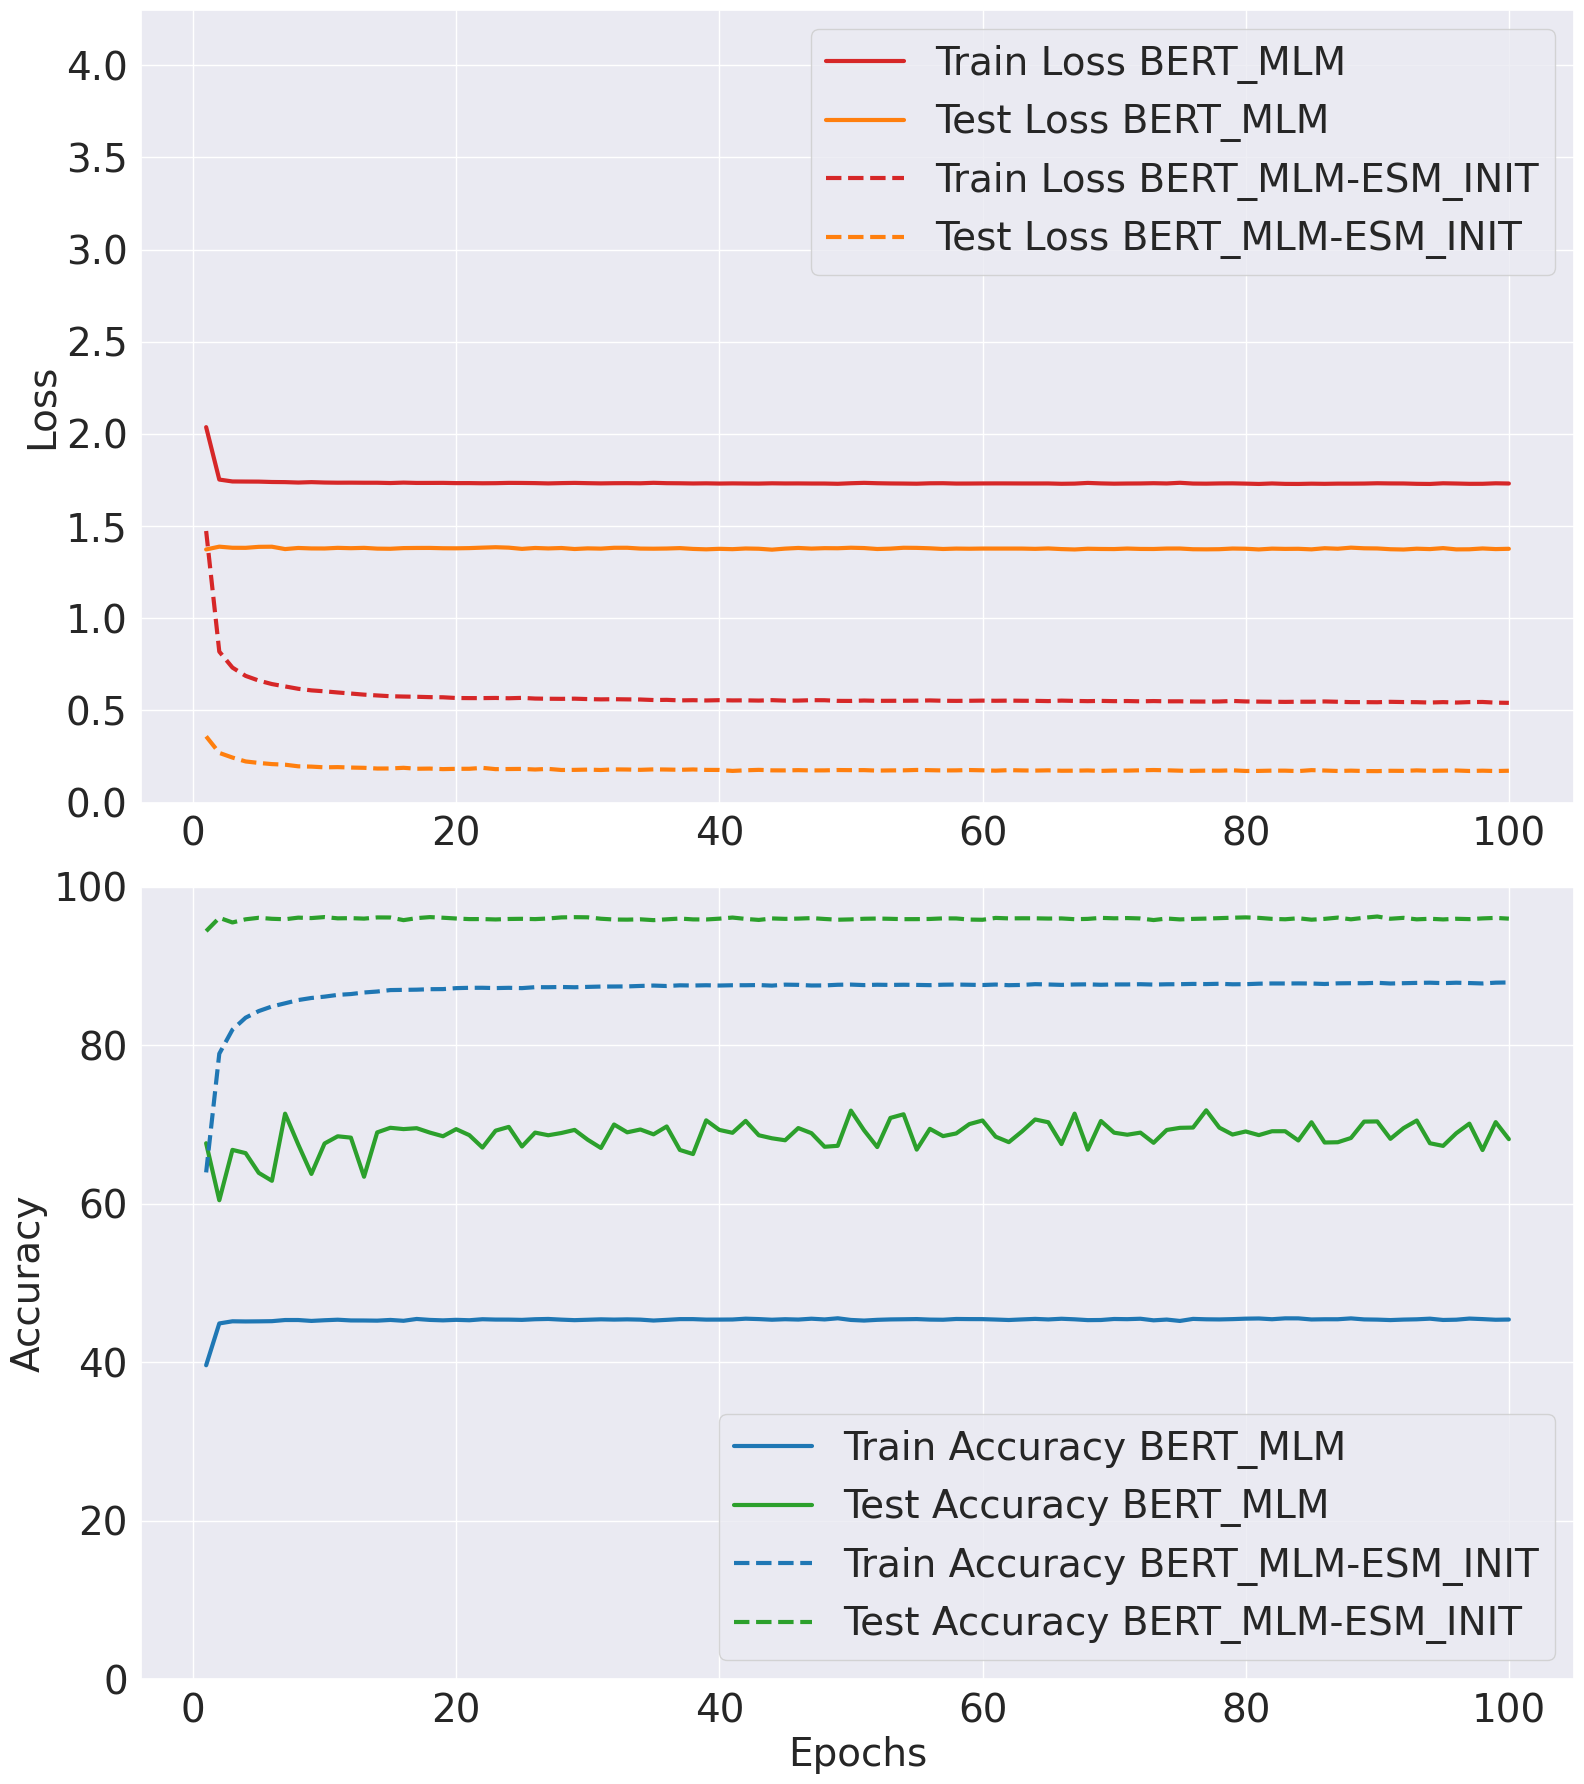

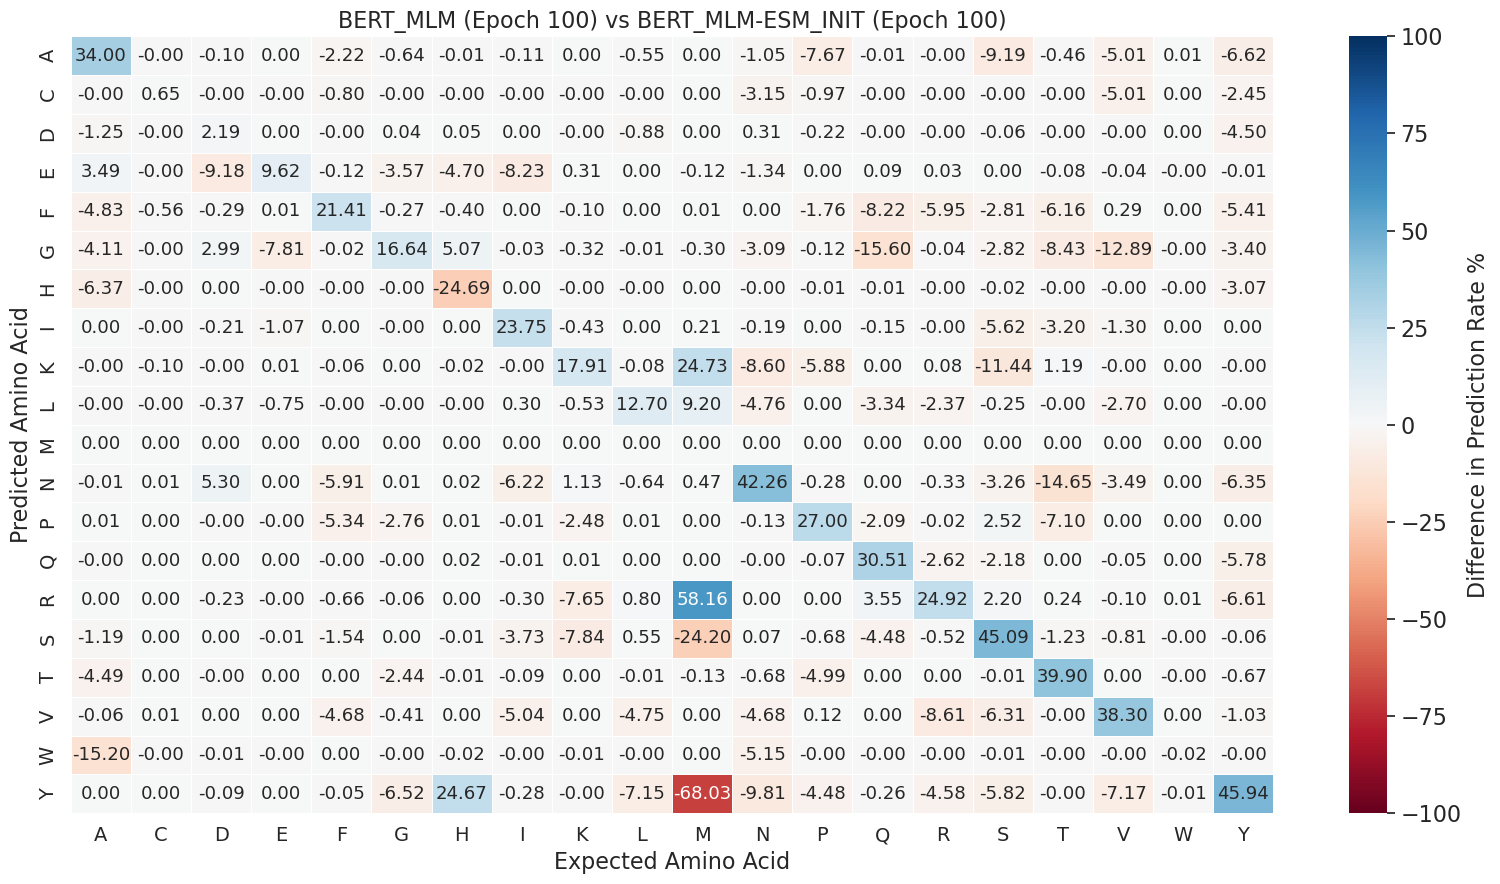

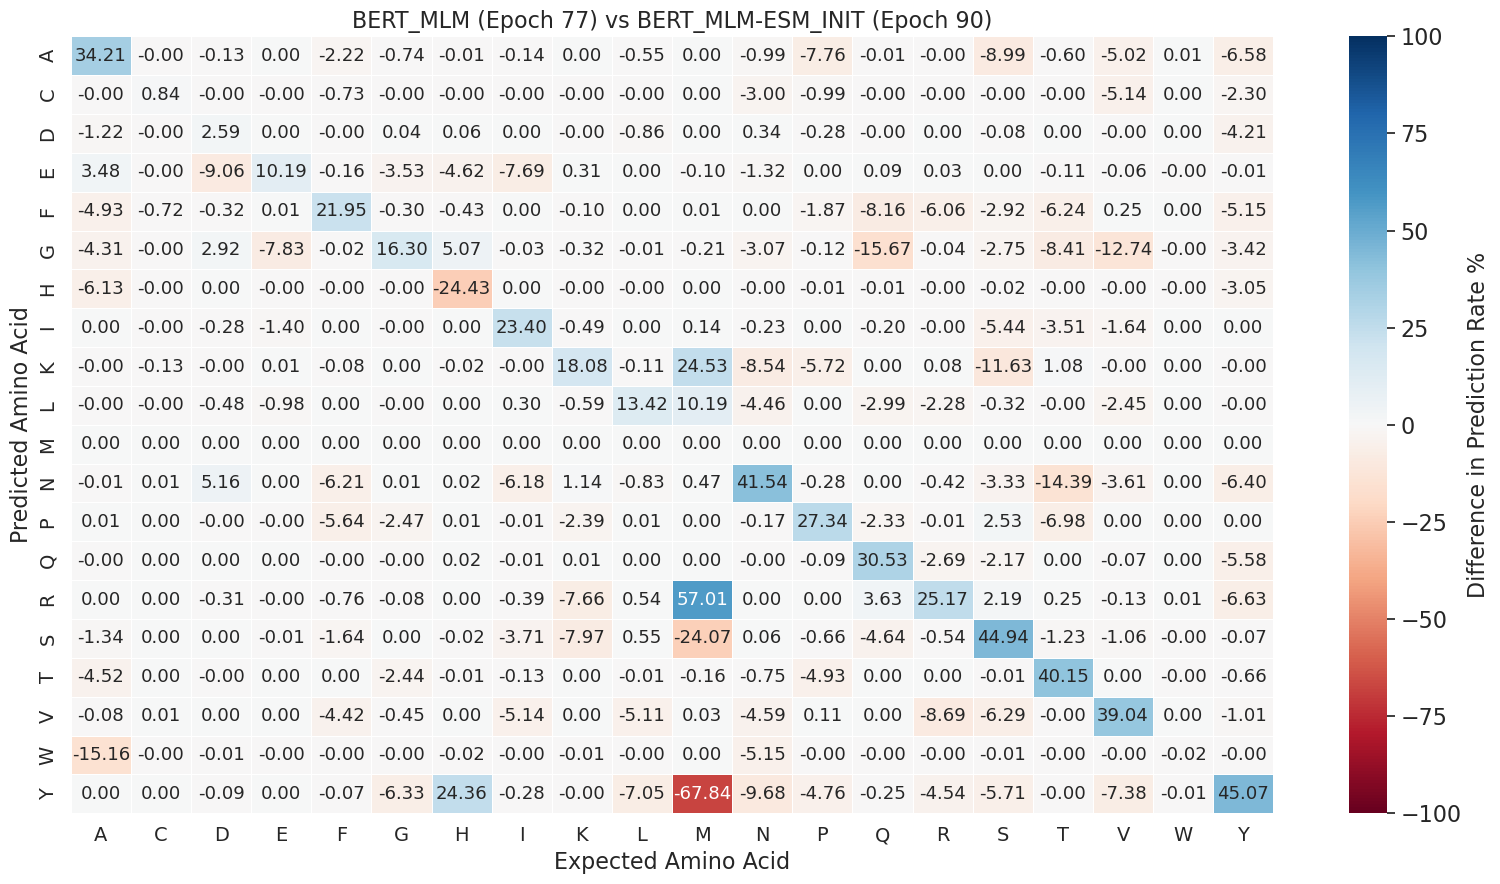

In [234]:
metrics_img = f"../../results/plots/model_comparisons/{run1.split('/')[4]}.vs.{run2.split('/')[4]}_metrics.pdf"
plot_comparative_log_file(
    metrics_csv_1=run1 + "_metrics.csv", 
    metrics_csv_2=run2 + "_metrics.csv", 
    metrics_img=metrics_img
)

# Last epoch comparison
preds_img = f"../../results/plots/model_comparisons/last_{run1.split('/')[4]}.vs.last_{run2.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run1 + "_predictions.csv", 
    preds_csv_2=run2 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run1_last_results[0], 
    cutoff_epoch_2=run2_last_results[0]
)

# Best epoch comparison
preds_img = f"../../results/plots/model_comparisons/best_{run1.split('/')[4]}.vs.best_{run2.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run1 + "_predictions.csv", 
    preds_csv_2=run2 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run1_best_results[0], 
    cutoff_epoch_2=run2_best_results[0]
)

Runtime difference:
- ***BERT-MLM***: Model took `12:47:55.739316` (D day(s), H:MM:SS.microseconds).
- ***BERT-MLM INITIALIZED WITH ESM***: Model took `13:13:40.750587` (D day(s), H:MM:SS.microseconds).

---
## DDP base model

GPUs: ***4***

Parameters
- n_epochs = ***100***
- batch_size = ***64***
- max_batch = ***-1***
- num_workers = ***64***

Optimizer/Scheduler
- lr = ***1e-5***
- betas = ***(0.9, 0.999)***
- weight_decay = ***0.01***
- d_model = model.bert.embedding_dim: ***320***
- n_warmup_steps = (len(train_data_loader.dataset) / (train_data_loader.batch_size \* 4)) \* 0.1: (277945/(64*4)) * 0.1 ≈ ***108.57***
BERT
- max_len = ***280***
- mask_prob = ***0.15***
- embedding_dim = ***320*** 
- dropout = ***0.1***
- n_transformer_layers = ***12***
- n_attn_heads = ***10***

*NOTE: These are per GPU numbers. Really the effective `batch_size` is ***(64 \* 4)***, and the effective `lr` is ***((1e-5) \* 4)***. `n_warmup_steps` is already adjusted based on the global batch size here, and the learning rate gets adjusted in the optimizer call.*



Best DDP-BERT_MLM: 
	Epoch: 43
	Test Accuracy: 96.3336 
	Test Loss: 0.1142

Last DDP-BERT_MLM: 
	Epoch: 100
	Test Accuracy: 96.1034 
	Test Loss: 0.1176



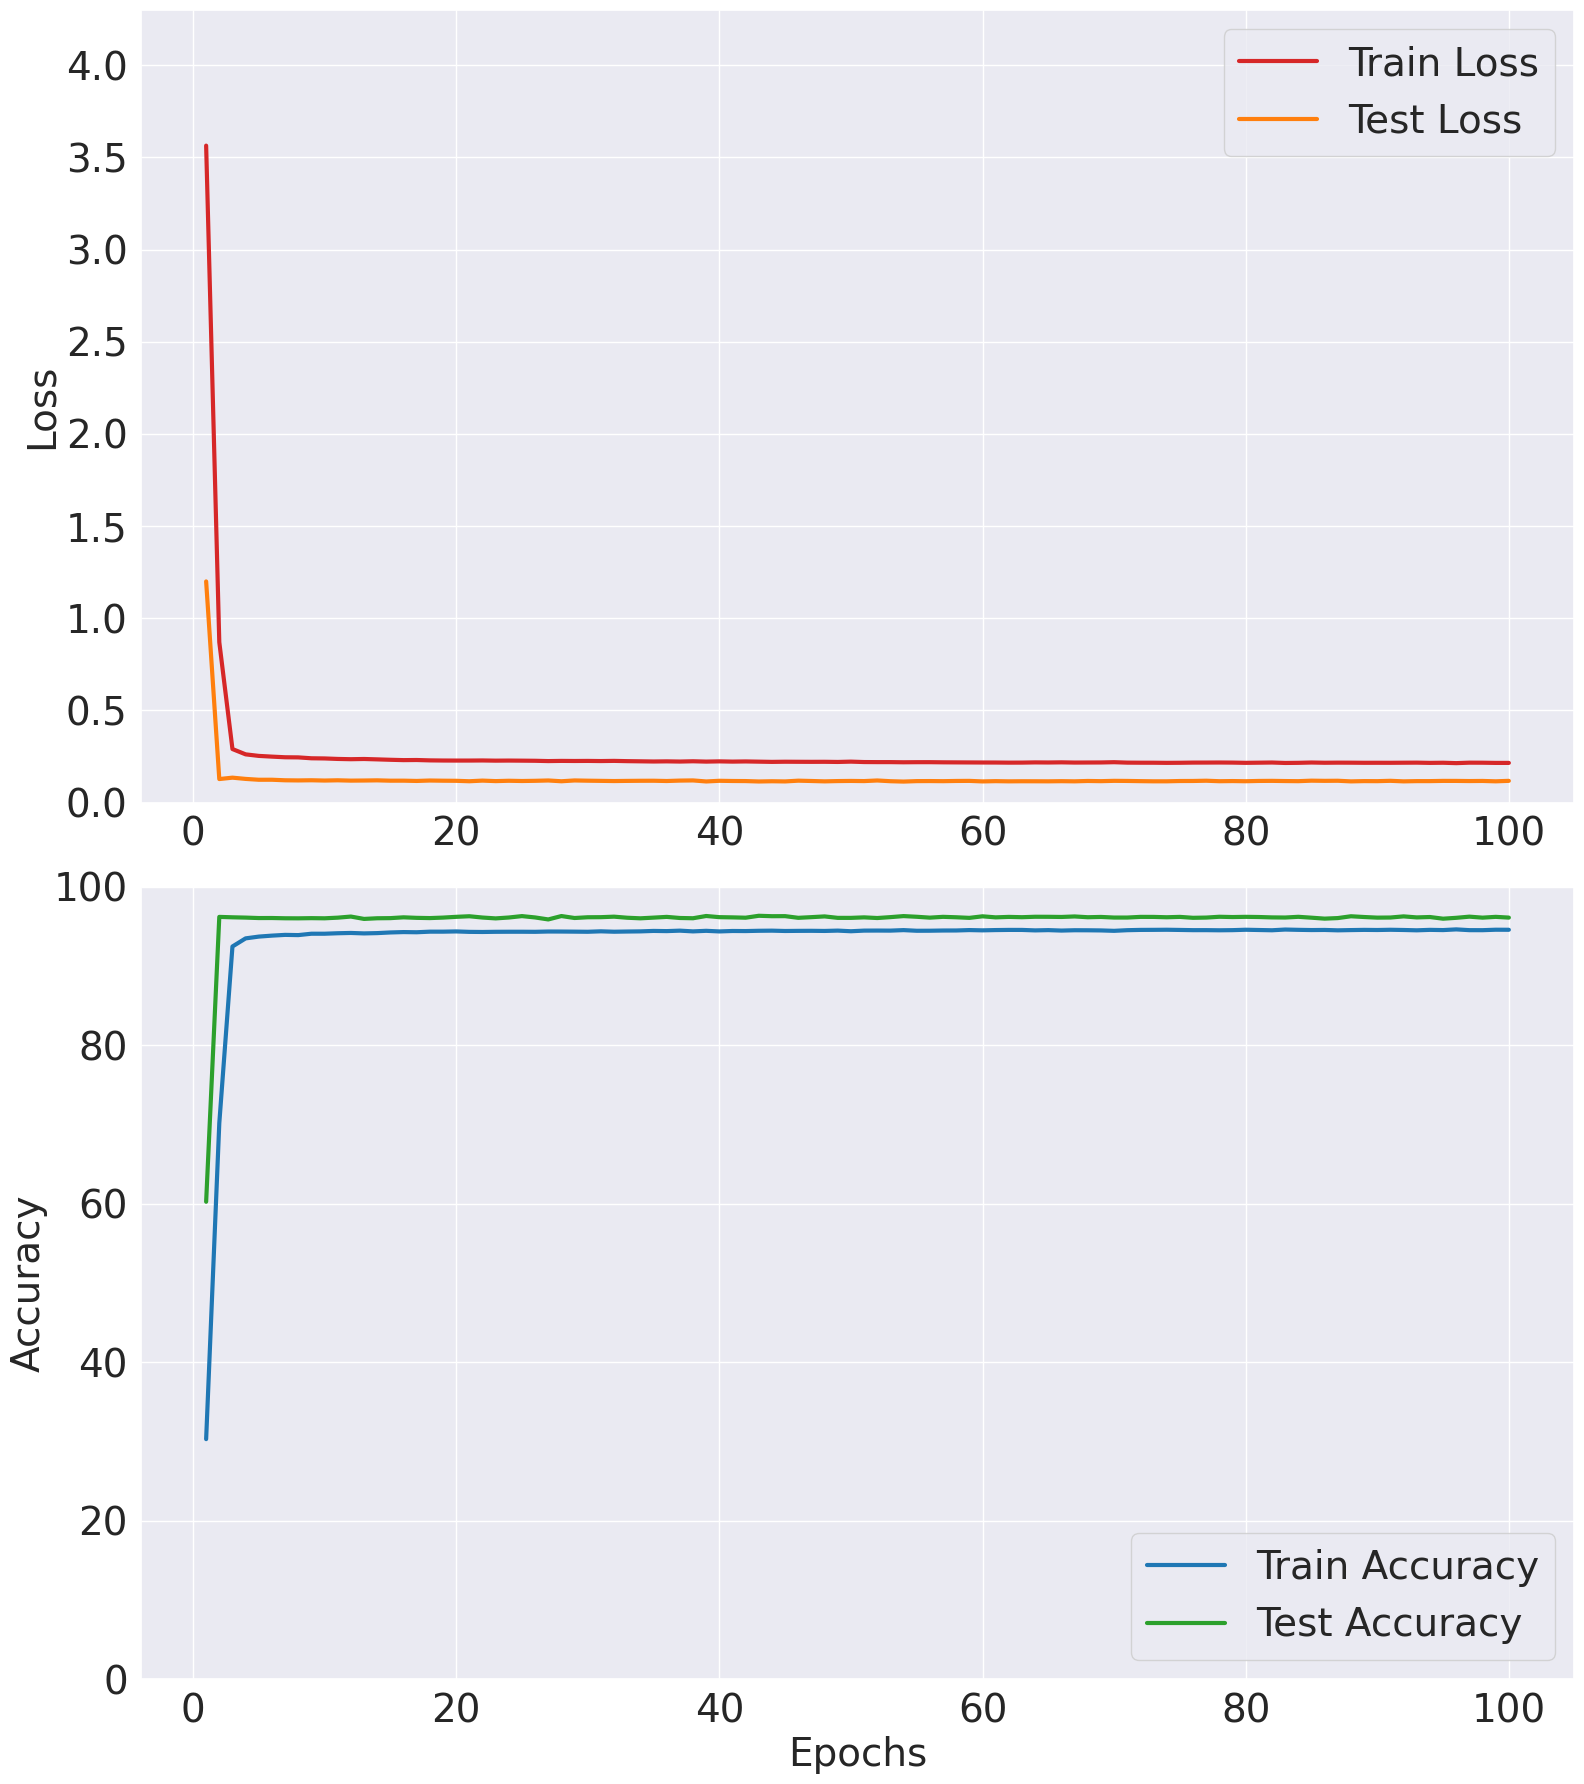

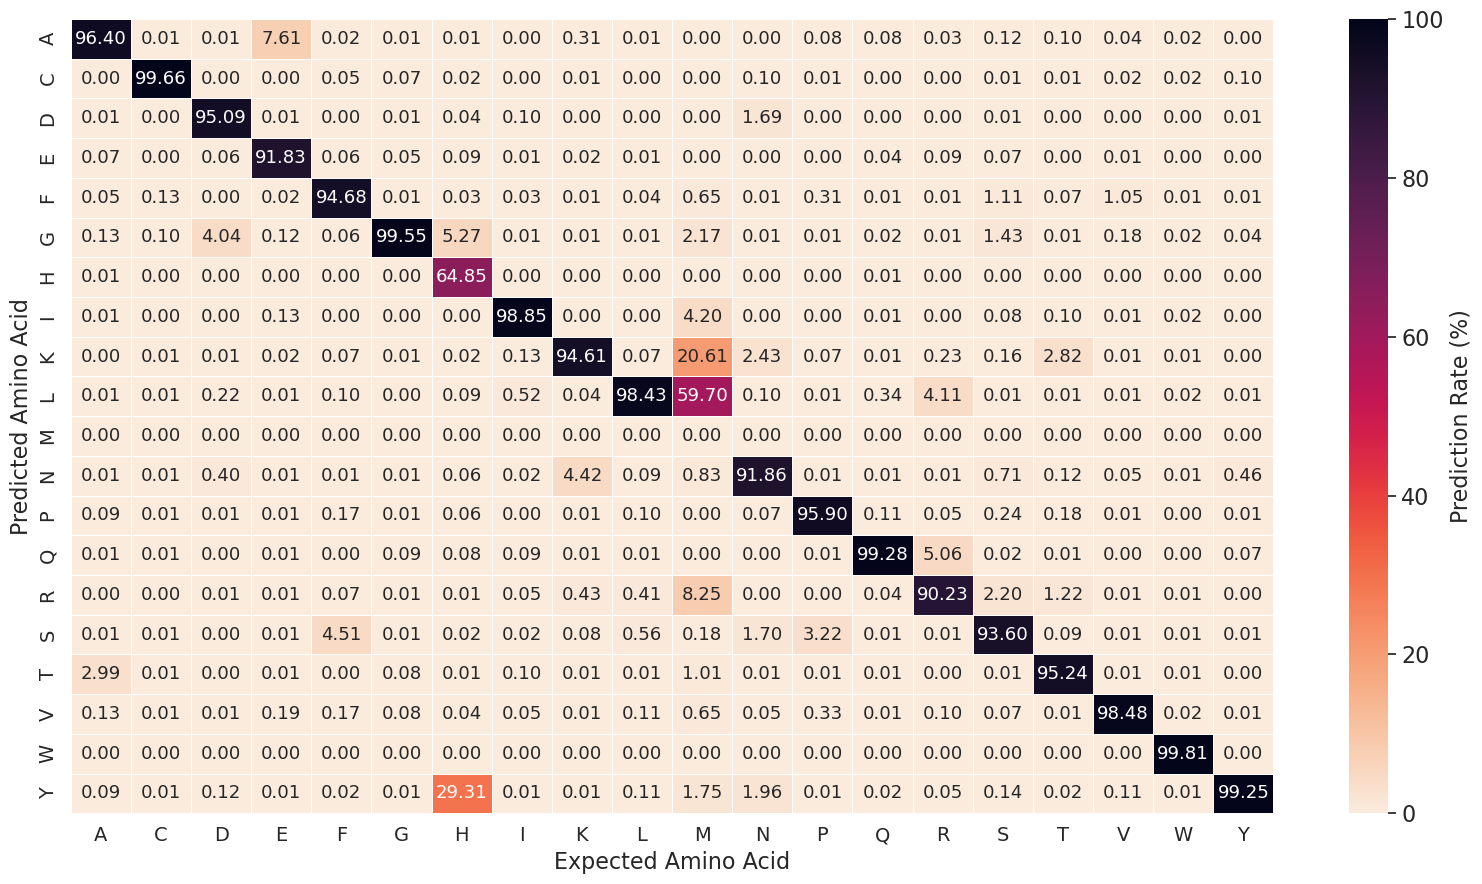

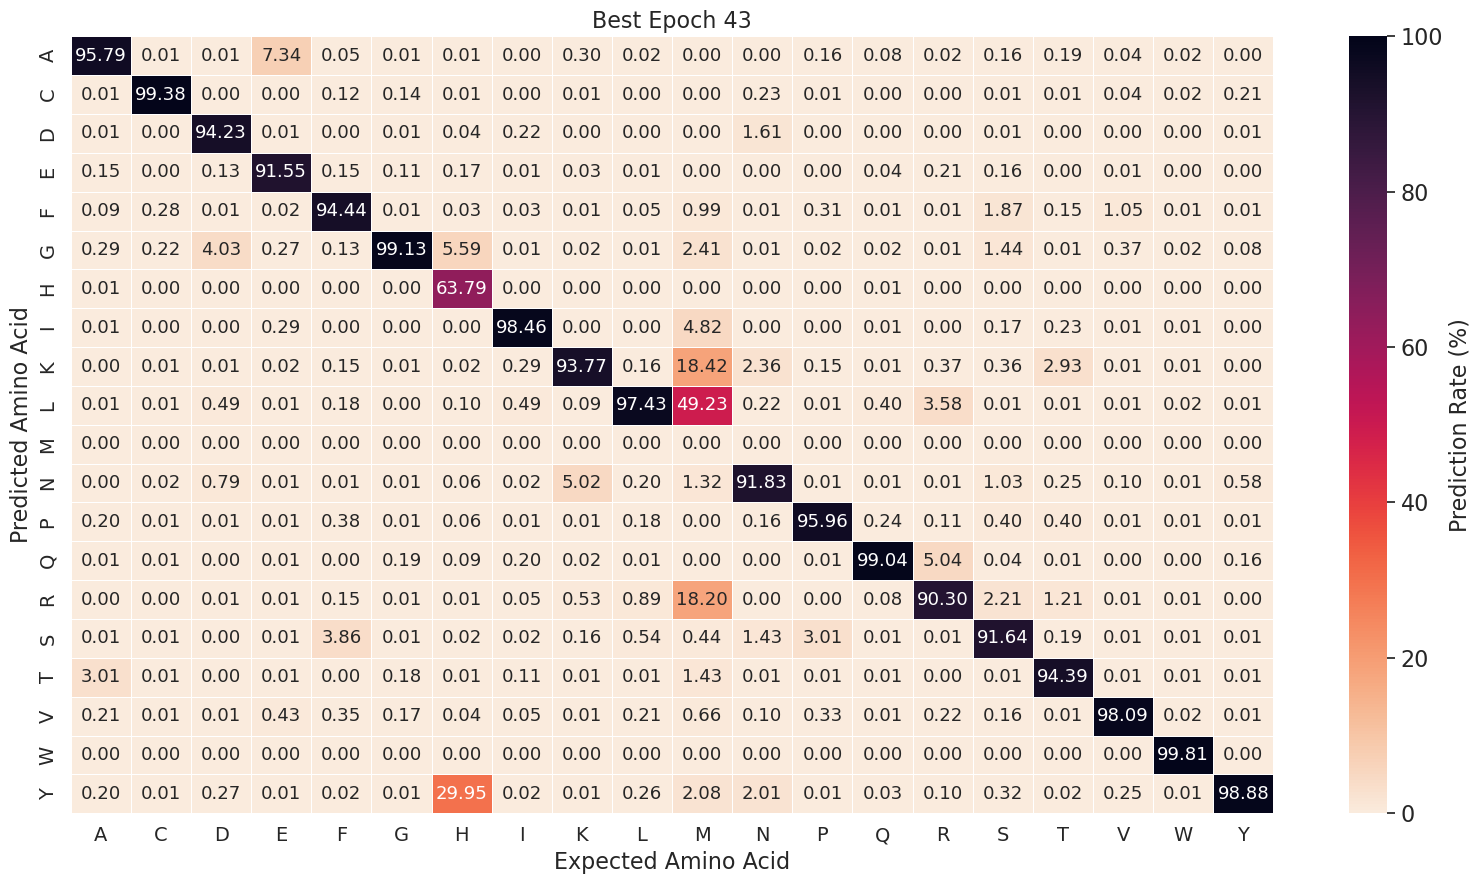

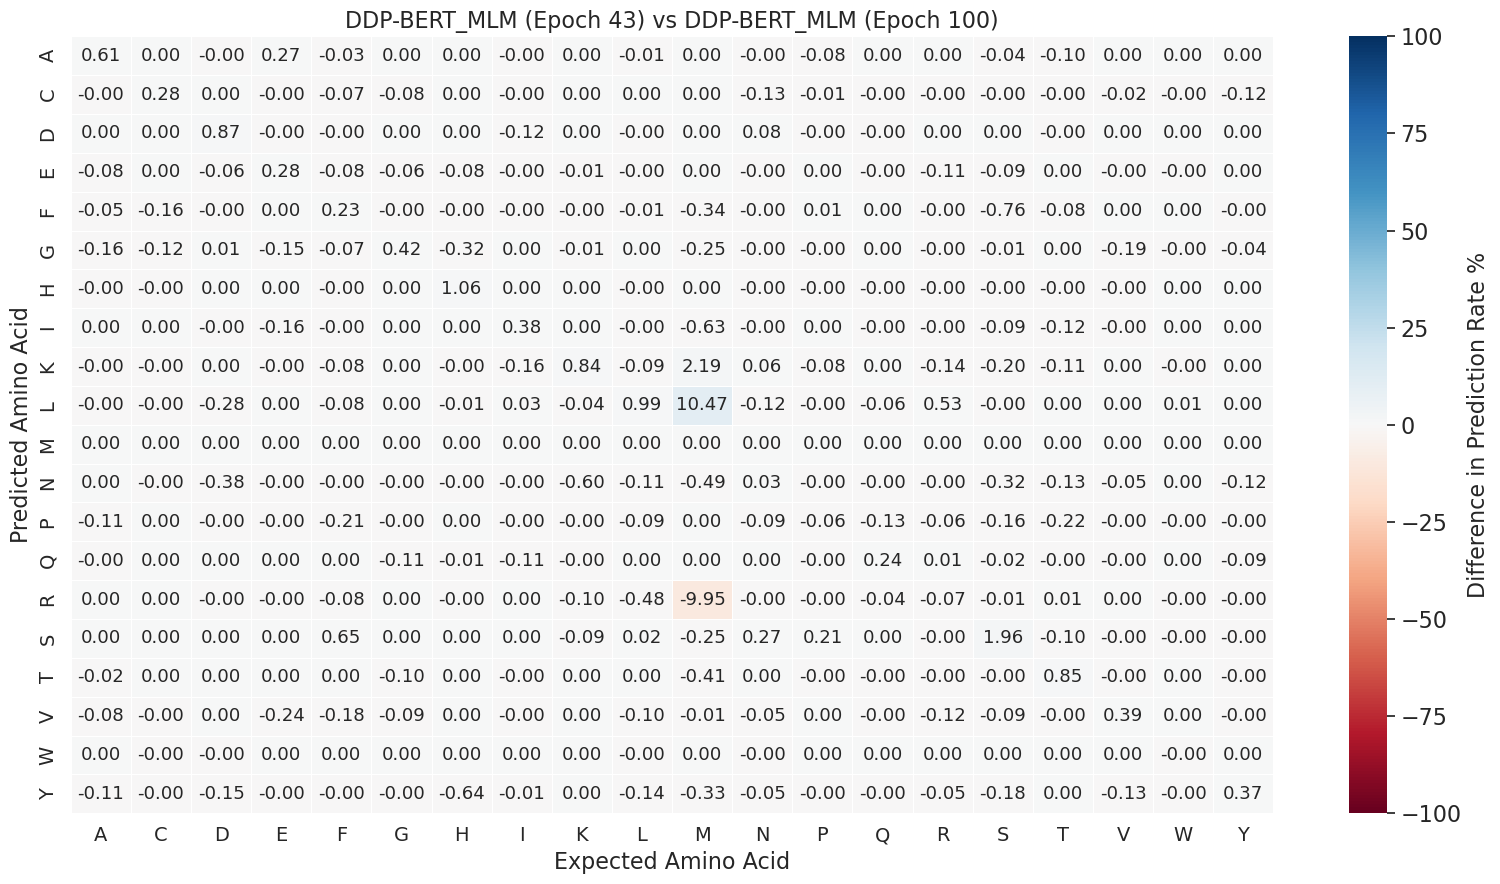

In [235]:
# DDP - BERT-MLM
run3 = "../../results/run_results/DDP-bert_mlm/DDP-bert_mlm-rbd-2024-09-26_13-09/DDP-bert_mlm-RBD-train_277945_test_69487"
plot_log_file(run3 + "_metrics.csv", run3 + "_metrics.pdf")

run3_best_results = find_best_epoch(run3 + "_metrics.csv")
print(f"Best {run3.split('/')[4].upper()}: \n\tEpoch: {run3_best_results[0]}\n\tTest Accuracy: {run3_best_results[1]:.4f} \n\tTest Loss: {run3_best_results[2]:.4f}\n")
run3_last_results = find_last_epoch(run3 + "_metrics.csv")
print(f"Last {run3.split('/')[4].upper()}: \n\tEpoch: {run3_last_results[0]}\n\tTest Accuracy: {run3_last_results[1]:.4f} \n\tTest Loss: {run3_last_results[2]:.4f}\n")

# Last Epoch
plot_aa_preds_heatmap(run3 + "_predictions.csv", run3 + "_predictions.pdf")

# Best Test Accuracy Epoch
plot_aa_preds_heatmap(run3 + "_predictions.csv", run3 + "_best_predictions.pdf", cutoff_epoch = run3_best_results[0])

# Compare the best vs last epoch
preds_img = run3 + f"_best_{run3.split('/')[4]}.vs.last_{run3.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run3 + "_predictions.csv", 
    preds_csv_2=run3 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run3_best_results[0], 
    cutoff_epoch_2=run3_last_results[0]
)

In [ ]:
# DDP - BERT-MLM INITIALIZED WITH ESM
run4 = "../../results/"
plot_log_file(run4 + "_metrics.csv", run4 + "_metrics.pdf")

run4_best_results = find_best_epoch(run4 + "_metrics.csv")
print(f"Best {run4.split('/')[4].upper()}: \n\tEpoch: {run4_best_results[0]}\n\tTest Accuracy: {run4_best_results[1]:.4f} \n\tTest Loss: {run4_best_results[2]:.4f}\n")
run4_last_results = find_last_epoch(run4 + "_metrics.csv")
print(f"Last {run4.split('/')[4].upper()}: \n\tEpoch: {run4_last_results[0]}\n\tTest Accuracy: {run4_last_results[1]:.4f} \n\tTest Loss: {run4_last_results[2]:.4f}\n")

# Last Epoch
plot_aa_preds_heatmap(run4 + "_predictions.csv", run4 + "_predictions.pdf")

# Best Test Accuracy Epoch
plot_aa_preds_heatmap(run4 + "_predictions.csv", run4 + "_best_predictions.pdf", cutoff_epoch = run4_best_results[0])

# Compare the best vs last epoch
preds_img = run4 + f"_best_{run4.split('/')[4]}.vs.last_{run4.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run4 + "_predictions.csv", 
    preds_csv_2=run4 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run4_best_results[0], 
    cutoff_epoch_2=run4_last_results[0]
)

### DDP Comparison - Subtractive heatmap and model runs

In [ ]:
metrics_img = f"../../results/plots/model_comparisons/{run3.split('/')[4]}.vs.{run4.split('/')[4]}_metrics.pdf"
plot_comparative_log_file(
    metrics_csv_1=run3 + "_metrics.csv", 
    metrics_csv_2=run4 + "_metrics.csv", 
    metrics_img=metrics_img
)

# Last epoch comparison
preds_img = f"../../results/plots/model_comparisons/last_{run3.split('/')[4]}.vs.last_{run4.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run3 + "_predictions.csv", 
    preds_csv_2=run4 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run3_last_results[0], 
    cutoff_epoch_2=run4_last_results[0]
)

# Best epoch comparison
preds_img = f"../../results/plots/model_comparisons/best_{run3.split('/')[4]}.vs.best_{run4.split('/')[4]}_heatmap.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run3 + "_predictions.csv", 
    preds_csv_2=run4 + "_predictions.csv", 
    preds_img=preds_img,
    cutoff_epoch_1=run3_best_results[0], 
    cutoff_epoch_2=run4_best_results[0]
)

Runtime difference:
- ***DDP BERT-MLM***: Model took `3:04:54.422876` (D day(s), H:MM:SS.microseconds).
- ***DDP BERT-MLM INITIALIZED WITH ESM***: Model took `<INSERT>` (D day(s), H:MM:SS.microseconds).